<a href="https://colab.research.google.com/github/gahyunson/food_management/blob/main/food_server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 한글 폰트 설정

In [ ]:
# 한글 폰트 설치 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,818 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


### module import

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

### train, test data load

In [ ]:
directory_list = [
    '/content/drive/MyDrive/final_project/food_img/train/',
    '/content/drive/MyDrive/final_project/food_img/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 train data와 test data로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir('/content/drive/MyDrive/final_project/food_img/img_folder/' + query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            #shutil.move(query + '/' + file_name, '/content/drive/MyDrive/final_project/food_img/train/' + query + '/' + file_name)
            shutil.copyfile('/content/drive/MyDrive/final_project/food_img/img_folder/'+ query + '/' + file_name, '/content/drive/MyDrive/final_project/food_img/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            #shutil.move(query + '/' + file_name, '/content/drive/MyDrive/final_project/food_img/food_split/test/' + query + '/' + file_name)
            shutil.copyfile('/content/drive/MyDrive/final_project/food_img/img_folder/'+ query + '/' + file_name, '/content/drive/MyDrive/final_project/food_img/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [ ]:
# /content/drive/MyDrive/final_project/food_img/train/ 여기를 원본경로로 두고 copyfile로 복사해서 사용함/ 이후 다른음식 추가시 사용가능/ 경로변경해야함
# dataset_split('01011001',200)
# dataset_split('01015010',200)
# dataset_split('01015013',200)
# dataset_split('04016001',200)
# dataset_split('12011008',200)

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/final_project/food_img'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 1500
테스트 데이터셋 크기: 30
클래스: ['01011001', '01015010', '01015013', '04016001', '12011008']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 저장한 모델 load하여 transfer learning

In [ ]:
#저장된 모델
model = torch.load('./drive/MyDrive/final_project/model/model_pytorch2.pt',map_location ='cpu')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
if not model:
  model = models.resnet34(pretrained=True)
  num_features = model.fc.in_features
  # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 5개로 교체하여 마지막 레이어 다시 학습
  model.fc = nn.Linear(num_features, 5)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  num_epochs = 50
  model.train()
  start_time = time.time()

  # 전체 반복(epoch) 수 만큼 반복하며
  for epoch in range(num_epochs):
      running_loss = 0.
      running_corrects = 0

      # 배치 단위로 학습 데이터 불러오기
      for inputs, labels in train_dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # 모델에 입력(forward)하고 결과 계산
          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(train_datasets)
      epoch_acc = running_corrects / len(train_datasets) * 100.

      # 학습 과정 중에 결과 출력
      print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: 01011001] (실제 정답: 01011001)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

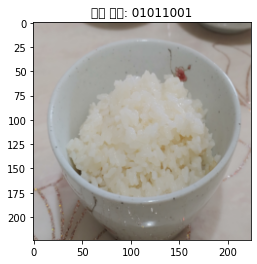

[예측 결과: 01011001] (실제 정답: 01011001)


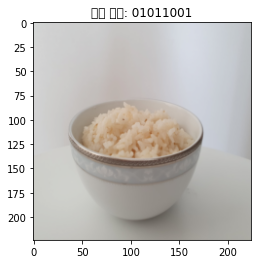

[예측 결과: 01015013] (실제 정답: 01015013)


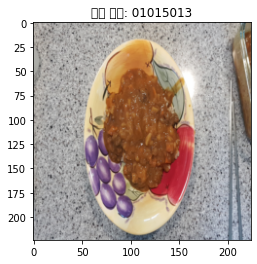

[예측 결과: 12011008] (실제 정답: 12011008)


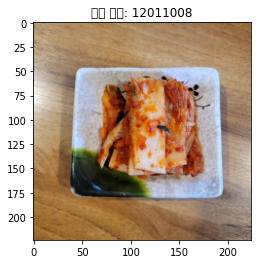

[예측 결과: 01011001] (실제 정답: 01011001)


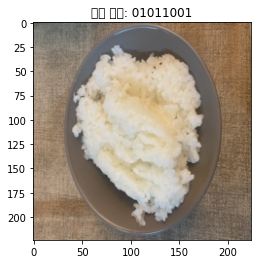

[예측 결과: 12011008] (실제 정답: 12011008)


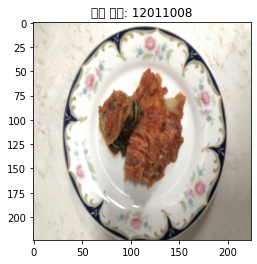

[예측 결과: 04016001] (실제 정답: 04016001)


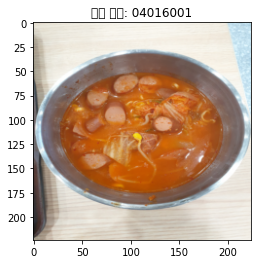

[예측 결과: 04016001] (실제 정답: 04016001)


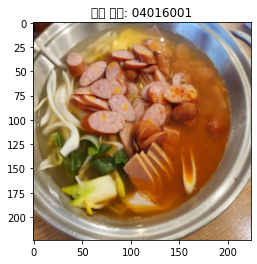

[Test Phase] Loss: 0.0011 Acc: 100.0000% Time: 17.8073s


In [ ]:
model.eval()
start_time = time.time()

if torch.cuda.is_available():
    model.cuda()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [ ]:
!pip install flask-ngrok

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://29ab-34-133-17-78.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

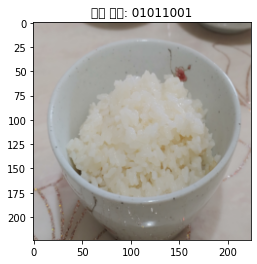

127.0.0.1 - - [07/Dec/2021 06:39:02] "POST / HTTP/1.1" 200 -


결과: {'class_name': '01011001'}


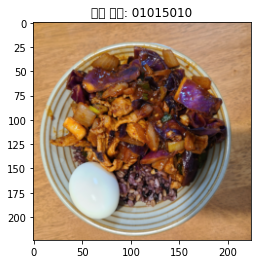

127.0.0.1 - - [07/Dec/2021 06:39:05] "POST / HTTP/1.1" 200 -


결과: {'class_name': '01015010'}


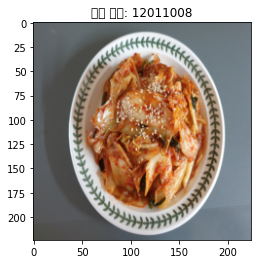

127.0.0.1 - - [07/Dec/2021 06:39:08] "POST / HTTP/1.1" 200 -


결과: {'class_name': '12011008'}


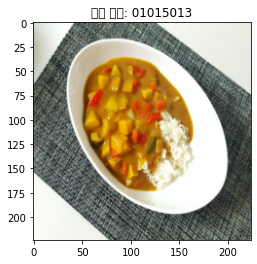

127.0.0.1 - - [07/Dec/2021 06:39:10] "POST / HTTP/1.1" 200 -


결과: {'class_name': '01015013'}


In [ ]:
run_with_ngrok(app)
app.run()
# url 사용

In [ ]:
#ngrok.io 서버에 보내면 됨
#test 폴더에 사용
#food_client 에서 접속